[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/seeding/hello_world.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/seeding/hello_world.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/seeding/hello_world.ipynb)

TODO #1417

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from PySDM import Formulae
from PySDM.physics import in_unit, si
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.seeding import Settings, Simulation

In [3]:
n_sd_initial = 100
n_sd_seeding = 100
rain_water_radius_threshold = .1 * si.mm
formulae = Formulae(seed=100)

simulations = {
    case: Simulation(
        Settings(
            n_sd_initial=n_sd_initial,
            n_sd_seeding=n_sd_seeding,
            rain_water_radius_threshold=rain_water_radius_threshold,
            super_droplet_injection_rate={
                'seeding': lambda time: 1 if 5 * si.min < time < 10 * si.min else 0,
                'no seeding': lambda _: 0,
            }[case],
            formulae=formulae,
        )
    )
    for case in ('seeding', 'no seeding')
}    

In [4]:
outputs = {case: simulations[case].run() for case in simulations}

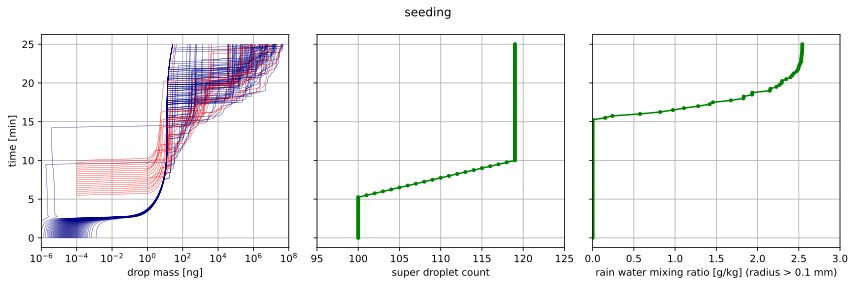

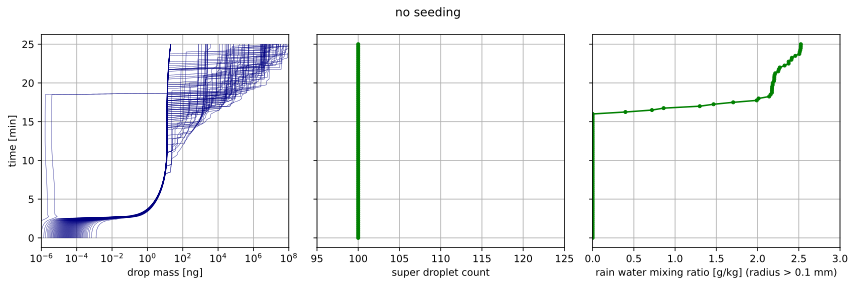

In [5]:
for case, output in outputs.items():
    time = output['products']['time']
    water_mass = output['attributes']['water mass']
    
    fig, axs = pyplot.subplot_mosaic(
        [['a', 'b', 'c']],
        sharey=True,
        figsize=(12, 4),
        tight_layout=True
    )
    
    for drop_id in range(water_mass.shape[1]):
        axs['a'].plot(
            in_unit(water_mass[:, drop_id], si.ng),
            in_unit(time, si.min),
            color="navy" if np.isfinite(water_mass[0, drop_id]) else "red",
            linewidth=0.333,
        )
    axs['a'].set_ylabel("time [min]")
    axs['a'].set_xlabel("drop mass [ng]")
    axs['a'].grid()
    axs['a'].set_xscale("log")
    axs['a'].set_xlim(1e-6, 1e8)

    axs['b'].plot(
        output['products']['sd_count'],
        in_unit(time, si.min),
        marker='.',
        color='green',
    )
    axs['b'].set_xlabel("super droplet count")
    axs['b'].grid()
    axs['b'].set_xlim(95, 125)

    axs['c'].plot(
        in_unit(output['products']['rain water mixing ratio'], si.g/si.kg),
        in_unit(time, si.min),
        marker='.',
        color='green',        
    )
    axs['c'].set_xlabel(f"rain water mixing ratio [g/kg] (radius > {in_unit(rain_water_radius_threshold, si.mm)} mm)")
    axs['c'].grid()
    axs['c'].set_xlim(0, 3)

    fig.suptitle(case)
    show_plot(f"hello_world_{case.replace(' ', '_')}.pdf")